In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *

# if dataset is in drive
#from google.colab import drive
#drive.mount(path := '/drive')
#path += '/MyDrive/MMA/dataset.csv'
# else
path = '../data/dataset.csv'

random_state = 42
criterion = 'log_loss'

In [21]:
df = pd.read_csv(path, low_memory=False).drop(['fight_id', 'f_1', 'f_2', 'finish_time'], axis=1)
df[:1]

,winner,weight_class,result,finish_round,knockdownsA,total_strikes_attA,total_strikes_succA,sig_strikes_attA,sig_strikes_succA,takedown_attA,...,sig_strikes_attB,sig_strikes_succB,takedown_attB,takedown_succB,submission_attB,reversalsB,ctrl_timeB,wins decB,wins subB,wins koB
0,0,2,0,2,0.000556,0.239795,0.161637,0.134006,0.066257,0.014064,...,0.175345,0.082486,0.000988,0.000988,0.0,0.0,0.040564,1,0,1


In [22]:
targets = df[ts := ['winner', 'result', 'finish_round']]
features = df.drop(ts, axis=1)

targets.shape, features.shape

((2869, 3), (2869, 27))

Split data into test/train.

In [23]:
Xtrain, Ytrain = features[500:], targets[500:]
Xtest, Ytest   = features[:500], targets[:500]

Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((2369, 27), (2369, 3), (500, 27), (500, 3))

# Predicting the winner (A or B)

In [24]:
ytrain = Ytrain['winner']
ytest  = Ytest['winner']

In [25]:
tree_winner = DecisionTreeClassifier(
    criterion=criterion,
    random_state=42,
).fit(Xtrain, ytrain)

predictions_train = tree_winner.predict(Xtrain)
predictions_test  = tree_winner.predict(Xtest)

print(f'{accuracy_score(ytrain, predictions_train) * 100:.0f}%')
print(f'{accuracy_score(ytest, predictions_test) * 100:.0f}%')

100%
49%


In [26]:
print(f'It looks like we are overfitting, let\'s look at the number of leaves: {tree_winner.get_n_leaves()}.')

It looks like we are overfitting, let's look at the number of leaves: 464.


In [27]:
def find_ccp_alpha(tree, xs, ys, xt, yt):
    alphas = np.linspace(0, 0.005, 200)
    train, test = [], []
    for alpha in alphas:
        tree.set_params(ccp_alpha=alpha)
        tree.fit(xs, ys)

        train.append(accuracy_score(ys, tree.predict(xs)))
        test.append(accuracy_score(yt, tree.predict(xt)))

    plt.plot(alphas, train, color='grey')
    plt.plot(alphas, test, color='black')
    plt.ylabel('accuracy')
    plt.xlabel('ccp-alpha value')
    plt.legend(['Training Data', 'Testing Data'])

max_depth = np.log2(len(Xtrain)).astype(int)
min_samples_leaf = 25

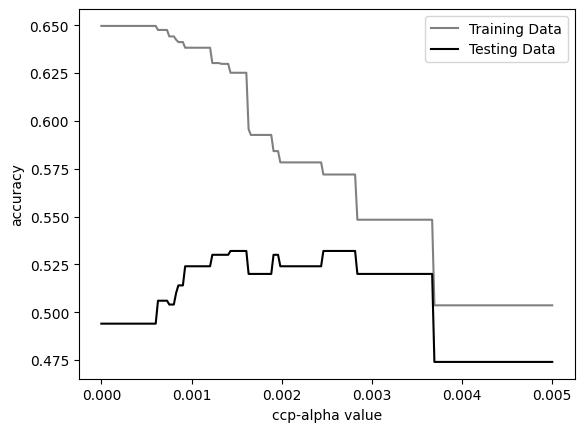

In [28]:
tree_winner = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
)

find_ccp_alpha(tree_winner, Xtrain, ytrain, Xtest, ytest)

In [29]:
tree_winner = DecisionTreeClassifier(
    random_state=random_state,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    ccp_alpha=0.0017,
).fit(Xtrain, ytrain)

predictions_train = tree_winner.predict(Xtrain)
predictions_test  = tree_winner.predict(Xtest)

print(f'{accuracy_score(ytrain, predictions_train) * 100:.2f}%')
print(f'{accuracy_score(ytest, predictions_test) * 100:.2f}%')

59.27%
52.00%


# Predicting the result (KO, Sub, Dec)

In [30]:
ytrain = Ytrain['result']
ytest  = Ytest['result']

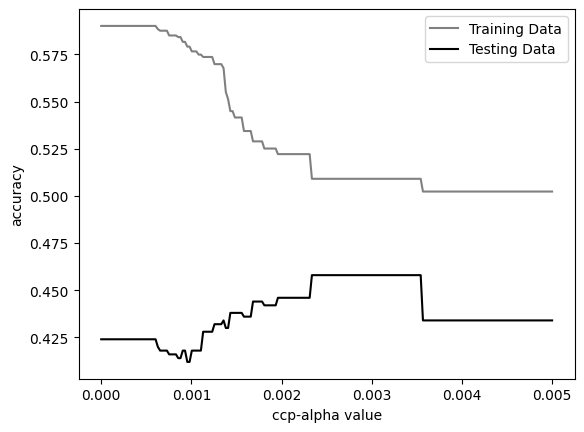

In [31]:
tree_result = DecisionTreeClassifier(
    max_depth=np.log2(len(Xtrain)).astype(int),
    min_samples_leaf=25,
    random_state=42,
)

find_ccp_alpha(tree_result, Xtrain, ytrain, Xtest, ytest)

In [32]:
tree_result = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    ccp_alpha=0.002,
).fit(Xtrain, ytrain)

predictions_train = tree_result.predict(Xtrain)
predictions_test  = tree_result.predict(Xtest)

print(f'{accuracy_score(ytrain, predictions_train) * 100:.2f}%')
print(f'{accuracy_score(ytest, predictions_test) * 100:.2f}%')

tree_result.get_n_leaves()

52.22%
44.60%


7

# Predicting the round (1, 2, 3)

In [33]:
ytrain = Ytrain['finish_round']
ytest  = Ytest['finish_round']

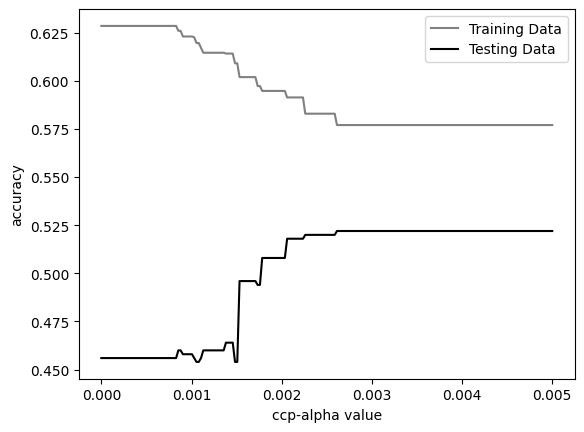

In [34]:
tree_round = DecisionTreeClassifier(
    random_state=random_state,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)

find_ccp_alpha(tree_round, Xtrain, ytrain, Xtest, ytest)

In [35]:
tree_round = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    ccp_alpha=0.0025,
).fit(Xtrain, ytrain)

predictions_train = tree_round.predict(Xtrain)
predictions_test  = tree_round.predict(Xtest)

print(f'{accuracy_score(ytrain, predictions_train) * 100:.2f}%')
print(f'{accuracy_score(ytest, predictions_test) * 100:.2f}%')

tree_round.get_n_leaves()

58.29%
52.00%


5

# Eval

In [36]:
def brier_score(targets, probabilities):
    Sum = 0.0
    for (probas, y) in zip(probabilities, targets):
        Sum += sum([(p - (1 if i == y else 0))**2 for i, p in enumerate(probas)])
    return Sum / len(targets)

In [19]:
probas_winner = tree_winner.predict_proba(Xtest)
preds_winner = tree_winner.predict(Xtest)

probas_result = tree_result.predict_proba(Xtest)
preds_result = tree_result.predict(Xtest)

probas_round  = tree_round.predict_proba(Xtest)
preds_round = tree_round.predict(Xtest)

print('\nAccuracies:')
print(accuracy_score(Ytest['winner'], preds_winner)*100)
print(accuracy_score(Ytest['result'], preds_result)*100)
print(accuracy_score(Ytest['finish_round'], preds_round)*100)

print('\nF1:')
print(f1_score(Ytest['winner'], preds_winner))
print(f1_score(Ytest['result'], preds_result, average='weighted'))
print(f1_score(Ytest['finish_round'], preds_round, average='weighted'))

print('\nLog-Losses:')

print(log_loss(Ytest['winner'], probas_winner))
print(log_loss(Ytest['result'], probas_result))
print(log_loss(Ytest['finish_round'], probas_round))

print('\nBrier-Scores:')

print(brier_score(Ytest['winner'], probas_winner))
print(brier_score(Ytest['result'], probas_result))
print(brier_score(Ytest['finish_round'], probas_round))


Accuracies:
52.0
44.6
52.0

F1:
0.589041095890411
0.3753718450934695
0.3970864661654136

Log-Losses:
0.719148795296745
1.0627012806233929
1.0321620533810891

Brier-Scores:
0.5200957774408774
0.6425432425883687
0.6175381122170858
